<a href="https://colab.research.google.com/github/Yversjcl/clasificador/blob/main/Propuesta_modelo_clasificaci%C3%B3n_stream_Piloto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Identificación de categorías Callback**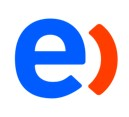

*IA en la clasificación de casos*

Propuesta de modelado para etiquetamiento automático - Piloto IA

# **Modelo:Random forest**

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
import nltk
from nltk.corpus import stopwords
import io

# Configuración de la aplicación
st.set_option('deprecation.showPyplotGlobalUse', False)

# Descargar stopwords de NLTK
nltk.download('stopwords', quiet=True)
spanish_stopwords = stopwords.words('spanish')

# Función para validar archivos CSV
def validate_csv(df, required_columns):
    """
    Valida que el DataFrame tenga las columnas requeridas
    """
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        st.error(f"Columnas faltantes: {', '.join(missing_columns)}")
        return False
    return True

# Función de preprocesamiento
def preprocess_text(text):
    """
    Preprocesa el texto para clasificación
    """
    return text.lower().strip()

# Configurar la interfaz de Streamlit
st.title("🔍 Sistema Avanzado de Clasificación Automática de Casos")
st.sidebar.title("Configuración")

# Opciones de hiperparámetros
st.sidebar.header("Configuración de Modelo")
n_estimators = st.sidebar.slider(
    "Número de Árboles (n_estimators)",
    min_value=10,
    max_value=300,
    value=100
)
max_depth = st.sidebar.slider(
    "Profundidad Máxima de Árboles",
    min_value=5,
    max_value=50,
    value=20
)
classification_threshold = st.sidebar.slider(
    "Umbral de Clasificación",
    min_value=0.0,
    max_value=1.0,
    value=0.5,
    step=0.05
)

# Subida de archivos
st.sidebar.header("1. Cargar Archivos")
diccionario_file = st.sidebar.file_uploader(
    "Cargar Diccionario CSV",
    type=["csv"]
)
formularios_file = st.sidebar.file_uploader(
    "Cargar Formularios CSV",
    type=["csv"]
)

# Contenedor principal para resultados
if diccionario_file and formularios_file:
    try:
        # Leer archivos cargados
        diccionario_df = pd.read_csv(diccionario_file, delimiter=';')
        formularios_df = pd.read_csv(formularios_file, delimiter=';')

        # Validar columnas requeridas
        diccionario_validado = validate_csv(
            diccionario_df,
            ['Palabra', 'Clasificacion']
        )
        formularios_validado = validate_csv(
            formularios_df,
            ['LITERAL']
        )

        if diccionario_validado and formularios_validado:
            # Preprocesar datos
            diccionario_df['Palabra'] = diccionario_df['Palabra'].str.lower()
            formularios_df['LITERAL'] = formularios_df['LITERAL'].apply(preprocess_text)
            formularios_df['Clasificacion_Asignada'] = None

            # Clasificación inicial por diccionario
            for index, row in formularios_df.iterrows():
                literal = row['LITERAL']
                for _, dic_row in diccionario_df.iterrows():
                    if dic_row['Palabra'] in literal:
                        formularios_df.at[index, 'Clasificacion_Asignada'] = dic_row['Clasificacion']
                        break

            # Preparar datos para entrenamiento
            df_with_labels = formularios_df.dropna(subset=['Clasificacion_Asignada'])

            # Verificar si hay suficientes datos para entrenar
            if len(df_with_labels) > 0:
                X = df_with_labels['LITERAL']
                y = df_with_labels['Clasificacion_Asignada']

                # Dividir datos
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42
                )

                # Vectorización
                tfidf_vectorizer = TfidfVectorizer(
                    stop_words=spanish_stopwords,
                    max_features=500
                )
                X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
                X_test_tfidf = tfidf_vectorizer.transform(X_test)

                # Entrenar modelo con hiperparámetros personalizados
                rf_classifier = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    random_state=42
                )
                rf_classifier.fit(X_train_tfidf, y_train)

                # Predicción y probabilidades
                y_pred_proba = rf_classifier.predict_proba(X_test_tfidf)
                y_pred = (y_pred_proba.max(axis=1) >= classification_threshold).astype(int)

                # Métricas
                st.subheader("📊 Resultados del Modelo")
                col1, col2 = st.columns(2)

                with col1:
                    accuracy = accuracy_score(y_test, y_pred)
                    st.metric("Precisión", f"{accuracy:.2%}")

                with col2:
                    st.metric("Categorías", len(np.unique(y)))

                # Informe de clasificación
                st.text("📝 Informe Detallado:")
                st.text(classification_report(y_test, y_pred, zero_division=1))

                # Matriz de Confusión
                st.subheader("🔢 Matriz de Confusión")
                cm = confusion_matrix(y_test, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title('Matriz de Confusión')
                plt.ylabel('Verdadero')
                plt.xlabel('Predicho')
                st.pyplot(plt.gcf())
                plt.close()

                # Curva ROC
                st.subheader("📈 Curva ROC")
                plt.figure(figsize=(10, 8))
                for i in range(len(np.unique(y))):
                    y_true_bin = (y_test == np.unique(y)[i]).astype(int)
                    fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(
                        fpr, tpr,
                        label=f'ROC {np.unique(y)[i]} (AUC = {roc_auc:.2f})'
                    )
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Tasa de Falsos Positivos')
                plt.ylabel('Tasa de Verdaderos Positivos')
                plt.title('Curva ROC Multiclase')
                plt.legend(loc="lower right")
                st.pyplot(plt.gcf())
                plt.close()

                # Distribución de Categorías
                st.subheader("📊 Distribución de Categorías")
                plt.figure(figsize=(14, 10))
                sns.countplot(
                    y='Clasificacion_Asignada',
                    data=formularios_df,
                    order=formularios_df['Clasificacion_Asignada'].value_counts().index
                )
                plt.title('Distribución de Categorías Asignadas')
                plt.xlabel('Categoría')
                plt.ylabel('Cantidad')
                plt.xticks(rotation=45)
                st.pyplot(plt.gcf())
                plt.close()

                # Clasificación de nuevos casos
                st.sidebar.header("2. Clasificar Nuevos Casos")
                nuevo_caso = st.sidebar.text_area("Ingrese un nuevo caso para clasificar")

                if st.sidebar.button("Clasificar Caso"):
                    if nuevo_caso:
                        # Preprocesar y vectorizar el nuevo caso
                        nuevo_caso_procesado = preprocess_text(nuevo_caso)
                        nuevo_caso_vectorizado = tfidf_vectorizer.transform([nuevo_caso_procesado])

                        # Predecir
                        prediccion_proba = rf_classifier.predict_proba(nuevo_caso_vectorizado)[0]
                        clase_predicha = rf_classifier.classes_[prediccion_proba.argmax()]
                        probabilidad = prediccion_proba.max()

                        st.sidebar.success(f"Clasificación: {clase_predicha}")
                        st.sidebar.info(f"Probabilidad: {probabilidad:.2%}")

                # Descargar resultados
                st.sidebar.header("3. Descargar Resultados")
                output_filename = 'Formulario_Clasificado.csv'
                formularios_df.to_csv(output_filename, index=False)

                with open(output_filename, "rb") as file:
                    st.sidebar.download_button(
                        label="Descargar CSV Clasificado",
                        data=file,
                        file_name=output_filename,
                        mime='text/csv'
                    )
            else:
                st.warning("No hay suficientes datos etiquetados para entrenar el modelo.")

    except Exception as e:
        st.error(f"Ocurrió un error: {e}")